In [1]:
from tqdm.notebook import tqdm
import pandas
import numpy
import matplotlib.pyplot as plt

from ProblemInstance import ProblemInstance
from baseline_intra import bl_intra_1
from baseline_pslice import bl_pslice
from baseline_pimlet import bl_pimlet
from baseline_request import bl_req_FCFS
from our_approach import leader_follower

cDeepArch: 400 image per context, 10+20 context
- cDeepArchContext: 400*30=12000 images
- cDeepArchObject: 400 images

DeepEar: for duration of 5h
- DeepEarInputLayer: 
- DeepEarAmbient: every 1.5s -> 12000
- DeepEarStress: every 5s -> 3600
- DeepEarEmotion: every 5s -> 3600
- DeepEarSpeaker: every 5s -> 3600

Gait:
- GaitExtractor: 118+20+118+20+118+118 = 512
- GaitIdentifierCNN: 3740+4936+2991+3941+7600+7600 = 30808
- GaitIdentifierLSTM: 3740+4936+2991+3941 = 15608
- GaitAuthenticLSTM: 7600+7600 = 15200


In [2]:
def get_ops(problem, plan):
    return problem.operation_per_second(*problem.get_pc_packages_from_plan(*plan))

def adjust_xticks_single_model(names, spaces):
    for i, (n, s) in enumerate(zip(names, spaces)):
        names[i] += " "*s
    return names

In [3]:
fontsize = 15
neurosim_dir = "NetStructure/"
summary_file = "NeuroSIMOut/summary.csv"
figure_dir = "figures/"
color_map = ["#ff8884", "indianred", "#f8ac8c",  "#2878b5", '#80b1d3', "#9ac9db"]
predef_N_X = numpy.array([12000, 400, 15600, 12000, 3600, 3600, 3600, 512, 90808, 
                          15608, 15608, 15200, 1000, 1000, 1000, 1000, 1000, 1000,])

In [4]:
n_req = 100
intra_ops = []
inter_ops = []
pslice_ops = []
pimlet_ops = []
our_ops = []

single_model_problem = ProblemInstance(neurosim_dir)
single_model_problem.read_nn_profile(summary_file)
N_M = single_model_problem.N_M
for i in tqdm(range(N_M)):
    single_model_problem.get_single_requests(n_req, i)
    plan_intra = bl_intra_1(single_model_problem) 
    intra_ops.append(get_ops(single_model_problem, plan_intra))
    package_inter = bl_req_FCFS(single_model_problem) 
    inter_ops.append(single_model_problem.operation_per_second(*package_inter))
    plan_pslice = bl_pslice(single_model_problem) 
    pslice_ops.append(get_ops(single_model_problem, plan_pslice))
    package_pimlet = bl_pimlet(single_model_problem) 
    pimlet_ops.append(single_model_problem.operation_per_second(*package_pimlet))
    plan_our = leader_follower(single_model_problem)
    our_ops.append(get_ops(single_model_problem, plan_our))


  0%|          | 0/18 [00:00<?, ?it/s]

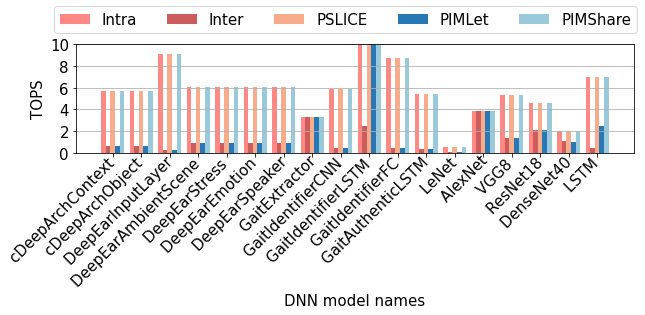

In [5]:
plt.figure(figsize=(10, 2))
names = single_model_problem.profile["DNN"].to_list() # + ["multiple model workload"]
names = adjust_xticks_single_model(names, 
       [30, 28, 30, 37, 24, 27, 26, 20, 28, 30, 25, 30, 9, 11, 10, 15, 19, 9])
n_col = 5
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+1.5)
plt.bar(base_xticks-width/2, intra_ops, width=width_per_col, label="Intra", color=color_map[0], align='center')
plt.bar(base_xticks-width/2+width_per_col, inter_ops, width=width_per_col, label="Inter", color=color_map[1], align='center')
plt.bar(base_xticks-width/2+width_per_col*2, pslice_ops, width=width_per_col, label="PSLICE", color=color_map[2], align='center')
plt.bar(base_xticks-width/2+width_per_col*3, pimlet_ops, width=width_per_col, label="PIMLet", color=color_map[3], align='center')
plt.bar(base_xticks-width/2+width_per_col*4, our_ops, width=width_per_col, label="PIMShare", color=color_map[5], align='center')
plt.xticks(ticks=base_xticks-width_per_col/2, labels=names,rotation=45, fontsize=fontsize, ha="center", va='center')
plt.yticks(fontsize=fontsize)
plt.ylim(0, 10)
plt.xlabel("DNN model names", fontdict={"size":fontsize})
plt.ylabel("TOPS", fontdict={"size":fontsize})
plt.legend(loc=(-0.04, 1.1), ncol=6, fontsize=fontsize)
plt.grid(axis='y')
plt.show()

In [ ]:
seed_set = numpy.arange(100)
n_req = 750
operations = []

multi_model_problem = ProblemInstance(neurosim_dir)
multi_model_problem.read_nn_profile(summary_file)
N_M = multi_model_problem.N_M
nmrange = numpy.arange(2, N_M+1)

intra_ops = numpy.zeros_like(nmrange).astype(float)
inter_ops = numpy.zeros_like(nmrange).astype(float)
pslice_ops = numpy.zeros_like(nmrange).astype(float)
pimlet_ops = numpy.zeros_like(nmrange).astype(float)
our_ops = numpy.zeros_like(nmrange).astype(float)


nn_ids = numpy.arange(N_M)
for seed in tqdm(seed_set):
    numpy.random.seed(seed)
    numpy.random.shuffle(nn_ids)
    for i, n_m in enumerate(nmrange):
        nn = nn_ids[:n_m]
        multi_model_problem.get_exact_requests(nn_ids=nn, n_x=predef_N_X[nn])
        operations.append(multi_model_problem.operations)
        
        plan_intra = bl_intra_1(multi_model_problem) 
        intra_ops[i] += get_ops(multi_model_problem, plan_intra)

        package_inter = bl_req_FCFS(multi_model_problem) 
        inter_ops[i] += multi_model_problem.operation_per_second(*package_inter)

        plan_pslice = bl_pslice(multi_model_problem) 
        pslice_ops[i] += get_ops(multi_model_problem, plan_pslice)

        package_pimlet = bl_pimlet(multi_model_problem) 
        pimlet_ops[i] += multi_model_problem.operation_per_second(*package_pimlet)

        plan_our = leader_follower(multi_model_problem)
        our_ops[i] += get_ops(multi_model_problem, plan_our)

        if False: # n_m == 18:
            print("\t", multi_model_problem.N_X.astype(int))
            print("\t", plan_intra[0]*(multi_model_problem.N_X>0))
            print("\t", (plan_our[0]+1)*(multi_model_problem.N_X>0))
            print("\t", plan_intra[1].values.astype(int)*(multi_model_problem.N_X>0))
            print("\t", plan_our[1]*(multi_model_problem.N_X>0))
            print("\t", plan_intra[2].values.astype(numpy.int)*(multi_model_problem.N_X>0))
            print("\t", plan_our[2]*(multi_model_problem.N_X>0))
        
intra_ops /= len(seed_set)
inter_ops /= len(seed_set)
pslice_ops /= len(seed_set)
pimlet_ops /= len(seed_set)
our_ops /= len(seed_set)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 2))
ax2 = ax1.twinx()
names = nmrange
n_col = 5
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+1.5)
ax1.bar(base_xticks-width/2, intra_ops, width=width_per_col, label="Intra", color=color_map[0], align='center')
ax1.bar(base_xticks-width/2+width_per_col, inter_ops, width=width_per_col, label="Inter", color=color_map[1], align='center')
ax1.bar(base_xticks-width/2+width_per_col*2, pslice_ops, width=width_per_col, label="PSLICE", color=color_map[2], align='center')
ax1.bar(base_xticks-width/2+width_per_col*3, pimlet_ops, width=width_per_col, label="PIMLet", color=color_map[3], align='center')
ax1.bar(base_xticks-width/2+width_per_col*4, our_ops, width=width_per_col, label="PIMShare", color=color_map[4], align='center')
ax1.set_xticks(ticks=base_xticks-width_per_col/2, labels=names,rotation=0, fontsize=fontsize)
tops_ticks = numpy.arange(0, 12+1, 3)
ax1.set_yticks(ticks=tops_ticks, labels=tops_ticks, fontsize=fontsize)
ax1.set_xlabel("Number of DNN models", fontsize=fontsize)
ax1.set_ylabel("TOPS", fontsize=fontsize)
ax1.legend(loc=(-0.02, 1.1), ncol=5, fontsize=fontsize)
ax1.grid(axis='y')

max_baseline = numpy.max(numpy.vstack([intra_ops, inter_ops, pslice_ops, pimlet_ops]), axis= 0)
ax2.plot(base_xticks-width_per_col/2, (our_ops-max_baseline)/max_baseline*100, marker="o", color="black")
ax2.set_ylabel("Improvement(%)", fontsize=fontsize)
improve_ticks = numpy.arange(0, 24+1, 6)
ax2.set_yticks(ticks=improve_ticks, labels=improve_ticks, fontsize=fontsize)

plt.show()

In [ ]:
seed = 5
n_req = 20000
n_req_step = 10
n_req_start = 2000

operations = []

multi_model_problem = ProblemInstance(neurosim_dir)
multi_model_problem.read_nn_profile(summary_file)
N_M = multi_model_problem.N_M
nxrange = numpy.arange(n_req_start, n_req+1, n_req//n_req_step)

x_intra_ops = numpy.zeros_like(nxrange).astype(float)
x_inter_ops = numpy.zeros_like(nxrange).astype(float)
x_pslice_ops = numpy.zeros_like(nxrange).astype(float)
x_pimlet_ops = numpy.zeros_like(nxrange).astype(float)
x_our_ops = numpy.zeros_like(nxrange).astype(float)

for i, n_x in tqdm(enumerate(nxrange)):
    multi_model_problem.get_random_requests_unequal(n_x, seed=seed)
    operations.append(multi_model_problem.operations)
    
    plan_intra = bl_intra_1(multi_model_problem) 
    x_intra_ops[i] += get_ops(multi_model_problem, plan_intra)
    
    package_inter = bl_req_FCFS(multi_model_problem) 
    x_inter_ops[i] += multi_model_problem.operation_per_second(*package_inter)
    
    plan_pslice = bl_pslice(multi_model_problem) 
    x_pslice_ops[i] += get_ops(multi_model_problem, plan_pslice)
    
    package_pimlet = bl_pimlet(multi_model_problem) 
    x_pimlet_ops[i] += multi_model_problem.operation_per_second(*package_pimlet)
    
    plan_our = leader_follower(multi_model_problem)
    x_our_ops[i] += get_ops(multi_model_problem, plan_our)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 2))
ax2 = ax1.twinx()
names = nxrange
n_col = 5
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+1.5)
ax1.bar(base_xticks-width/2, x_intra_ops, width=width_per_col, label="Intra", color=color_map[0], align='center')
ax1.bar(base_xticks-width/2+width_per_col, x_inter_ops, width=width_per_col, label="Inter", color=color_map[1], align='center')
ax1.bar(base_xticks-width/2+width_per_col*2, x_pslice_ops, width=width_per_col, label="PSLICE", color=color_map[2], align='center')
ax1.bar(base_xticks-width/2+width_per_col*3, x_pimlet_ops, width=width_per_col, label="PIMLet", color=color_map[3], align='center')
ax1.bar(base_xticks-width/2+width_per_col*4, x_our_ops, width=width_per_col, label="PIMShare", color=color_map[5], align='center')
ax1.set_xticks(ticks=base_xticks-width_per_col/2, labels=[n if i%2==0 else "" for i,n in enumerate(names)],rotation=0, fontsize=fontsize)
tops_ticks = numpy.arange(0, 4+1, 1)
ax1.set_yticks(ticks=tops_ticks, labels=tops_ticks, fontsize=fontsize)
ax1.set_xlabel("Number of requests", fontsize=fontsize)
ax1.set_ylabel("TOPS", fontsize=fontsize)
ax1.legend(loc=(-0.01, 1.1), ncol=10, fontsize=fontsize)
ax1.grid(axis='y')

max_baseline = numpy.max(numpy.vstack([x_intra_ops, x_inter_ops, x_pslice_ops, x_pimlet_ops]), axis= 0)
ax2.plot(base_xticks-width_per_col/2, (x_our_ops-max_baseline)/max_baseline*100, marker="o", color="black")
improve_ticks = numpy.arange(0, 45+1, 10)
ax2.set_yticks(ticks=improve_ticks, labels=improve_ticks, fontsize=fontsize)
ax2.set_ylabel("Improvement(%)", fontsize=fontsize)

plt.show()